In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, auc
from scipy.io import loadmat
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:


# Wczytanie pliku .mat (np. 'cardio.mat')
data = loadmat('datasets/satellite.mat')  # Zmień nazwę pliku na swój

# Pobranie X i y
X = data['X']  # Macierz cech
y = data['y'].flatten()  # Wektor etykiet, spłaszczony do 1D

# Sprawdzenie danych
print(f"Kształt X: {X.shape}")
print(f"Kształt y: {y.shape}")
print(f"Liczba normalnych (0): {np.sum(y == 0)}")
print(f"Liczba anomalii (1): {np.sum(y == 1)}")

Kształt X: (6435, 36)
Kształt y: (6435,)
Liczba normalnych (0): 4399
Liczba anomalii (1): 2036


In [12]:

# 1. Oddziel dane normalne (gdzie y == 0)
X_normal = X[y == 0]  # Tylko próbki z etykietą 0
y_normal = y[y == 0]  # Etykiety dla tych próbek (wszystkie 0)

# 2. Podziel dane normalne na treningowe i testowe (np. 70% trening, 30% test)
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(
    X_normal, y_normal, test_size=0.3, random_state=42
)

# 3. Oddziel anomalie (gdzie y == 1)
X_anomalies = X[y == 1]  # Tylko próbki z etykietą 1
y_anomalies = y[y == 1]  # Etykiety dla tych próbek (wszystkie 1)

# 4. Utwórz zbiór testowy: połącz dane normalne z testu z anomaliami
X_test = np.vstack([X_test_normal, X_anomalies])  # Łączenie macierzy w pionie
y_test = np.hstack([y_test_normal, y_anomalies])  # Łączenie wektorów w poziomie

# 5. Zbiór treningowy: tylko normalne dane z treningu
X_train = X_train_normal
y_train = y_train_normal  # Wszystkie etykiety to 0

# Sprawdzenie
print(f"Zbiór treningowy: {X_train.shape[0]} próbek (wszystkie normalne)")
print(f"Zbiór testowy: {X_test.shape[0]} próbek ({np.sum(y_test == 0)} normalne, {np.sum(y_test == 1)} anomalie)")

Zbiór treningowy: 3079 próbek (wszystkie normalne)
Zbiór testowy: 3356 próbek (1320 normalne, 2036 anomalie)


In [13]:

# Dopasowanie scalera do danych treningowych
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Funkcja do oceny modelu na danych testowych i OOD
def evaluate_model(model, X_test_scaled, y_test, X_ood_scaled=None, y_ood=None):
    # Wyniki dla danych testowych
    test_scores = model.score_samples(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, -test_scores)  # Negacja, bo niższe score to anomalie
    roc_auc = auc(fpr, tpr)
    print(f"AUC dla danych testowych: {roc_auc:.4f}")
    
    # Wyniki dla danych OOD (jeśli dostępne)
    if X_ood_scaled is not None and y_ood is not None:
        ood_scores = model.score_samples(X_ood_scaled)
        fpr_ood, tpr_ood, _ = roc_curve(y_ood, -ood_scores)
        roc_auc_ood = auc(fpr_ood, tpr_ood)
        print(f"AUC dla danych OOD: {roc_auc_ood:.4f}")
    
    return fpr, tpr, roc_auc


In [15]:

# 1. Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof.fit(X_train_scaled)
fpr_lof, tpr_lof, auc_lof = evaluate_model(lof, X_test_scaled, y_test)

AUC dla danych testowych: 0.8504


In [16]:

# 2. Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train_scaled)
fpr_iso, tpr_iso, auc_iso = evaluate_model(iso_forest, X_test_scaled, y_test)

AUC dla danych testowych: 0.8170


In [17]:

# 3. One-Class SVM
ocsvm = OneClassSVM(nu=0.1, kernel='rbf')
ocsvm.fit(X_train_scaled)
fpr_svm, tpr_svm, auc_svm = evaluate_model(ocsvm, X_test_scaled, y_test)

AUC dla danych testowych: 0.7304


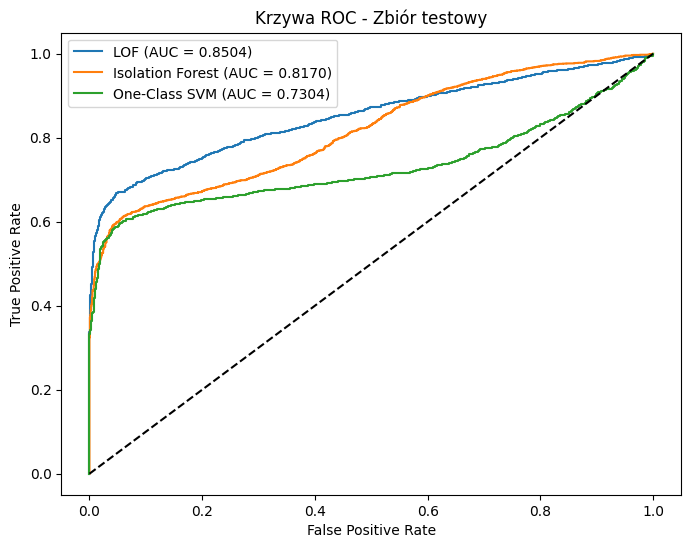

In [18]:
# Wykres ROC dla danych testowych
plt.figure(figsize=(8, 6))
plt.plot(fpr_lof, tpr_lof, label=f'LOF (AUC = {auc_lof:.4f})')
plt.plot(fpr_iso, tpr_iso, label=f'Isolation Forest (AUC = {auc_iso:.4f})')
plt.plot(fpr_svm, tpr_svm, label=f'One-Class SVM (AUC = {auc_svm:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - Zbiór testowy')
plt.legend()
plt.show()